<a href="https://colab.research.google.com/github/gcvasconcelos/unb-classification_political_bias/blob/main/tcc_manifestos_3classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from time import time
import logging
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle
from sklearn.metrics import ConfusionMatrixDisplay

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


In [ ]:
!pip install simpletransformers 

     |████████████████████████████████| 249 kB 16.0 MB/s 
     |████████████████████████████████| 10.1 MB 44.2 MB/s 
     |████████████████████████████████| 4.0 MB 41.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 325 kB 65.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 1.8 MB 60.1 MB/s 
     |████████████████████████████████| 1.2 MB 54.5 MB/s 
     |████████████████████████████████| 895 kB 57.4 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 13.6 MB/s 
     |████████████████████████████████| 181 kB 70.0 MB/s 
     |████████████████████████████████| 144 kB 72.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.5 MB/s 
     |████████████████████████████████| 212 kB 55.8 MB/s 
     |████████████████████████████████| 136 kB 76.8 MB/s 
     |█████████████

In [ ]:
from simpletransformers.classification import ClassificationModel
import logging

import sklearn
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
code_df = pd.read_csv('/content/drive/MyDrive/UnB/TCC/dados_processados/manifestos_sentences_preproc_v2.csv', keep_default_na=False)
code_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63919 entries, 0 to 63918
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MANIFEST_ID  63919 non-null  object 
 1   TEXT         63919 non-null  object 
 2   TEXT_TOKEN   63919 non-null  object 
 3   TEXT_LEMMA   63919 non-null  object 
 4   DOMAIN_CODE  63919 non-null  int64  
 5   DOMAIN_NAME  63919 non-null  object 
 6   CODE         63919 non-null  float64
 7   LABEL        63919 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.9+ MB


In [ ]:
code_df[['MANIFEST_ID','TEXT', 'CODE']].sample(5)

,MANIFEST_ID,TEXT,CODE
58634,35313_201910,"reducao da carga fiscal sobre imoveis, atraves...",408.0
25370,180310_201010,os alunos ficam em media 4 horas por dia na es...,506.0
1626,180230_198911,essas terras tiveram valorizacao de 2.000% dep...,403.0
38165,35211_201106,por um estado decente nas relacoes de trabalho.,701.0
27283,180310_201410,15. garantia de espacos publicos para a pratic...,502.0


In [ ]:
code_df[['TEXT','TEXT_TOKEN','TEXT_LEMMA']].sample(5)

,TEXT,TEXT_TOKEN,TEXT_LEMMA
16881,"com uma participacao articulada dos estados, m...",participacao articulada estados municipios com...,participacao articular estar municipios comuni...
45806,valorizar as carreiras docentes do ensino supe...,valorizar carreiras docentes ensino superior c...,valorizar carreira docente ensinar superior cr...
1644,"em todos esses casos, o aporte do poder public...",casos aporte publico fundamental,caso aportar publicar fundamental
16016,apoio a gestao das associacoes produtivas das ...,gestao associacoes produtivas comunidades flor...,gestao associacoes produtivo comunidade florestar
12778,essa pratica de politica economica leva a dist...,pratica politica economica leva distorcoes pre...,praticar politicar economica levar distorcoes ...


Tratamentos finais para classificação para a base CODE

In [ ]:
code_df['CODE'] = code_df['CODE'].astype(str)

In [ ]:
code_df[['CODE', 'LABEL']].value_counts()

CODE   LABEL                                
504.0  welfare +                                7787
411.0  technology & infrastructure              7087
506.0  education +                              5199
503.0  equality +                               5015
303.0  gov-admin efficiency                     4644
501.0  environmentalism +                       3840
502.0  culture +                                3013
202.1  democracy: general +                     2848
416.2  sustainability +                         2770
701.0  labour groups +                          2694
410.0  economic growth +                        2539
402.0  incentives                               2273
605.1  law and order +                          2213
703.1  agriculture and farmers +                1999
403.0  market regulation                        1981
414.0  economic orthodoxy                       1740
301.0  decentralisation                         1726
401.0  free market economy                      1219
3

In [ ]:
domain_df = pd.read_csv('/content/drive/MyDrive/UnB/TCC/dados_processados/manifestos_sentences_preproc.csv', keep_default_na=False)
domain_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90482 entries, 0 to 90481
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MANIFEST_ID  90482 non-null  object
 1   TEXT         90482 non-null  object
 2   TEXT_TOKEN   90482 non-null  object
 3   TEXT_LEMMA   90482 non-null  object
 4   DOMAIN_CODE  90482 non-null  int64 
 5   DOMAIN_NAME  90482 non-null  object
 6   CODE         90482 non-null  object
 7   LABEL        90482 non-null  object
dtypes: int64(1), object(7)
memory usage: 5.5+ MB


Tratamentos finais para classificação para a base DOMAIN

In [ ]:
domain_df = domain_df[domain_df['DOMAIN_CODE'] != 0]

In [ ]:
domain_df[['DOMAIN_CODE', 'DOMAIN_NAME']].value_counts()

DOMAIN_CODE  DOMAIN_NAME                
5            Welfare and Quality of Life    25709
4            Economy                        24386
3            Political System                9718
7            Social Groups                   6915
6            Fabric of Society               5527
2            Freedom and Democracy           4989
1            External Relations              4375
dtype: int64

## Modelos padrão

In [ ]:
def classify(df, text_column, label_column, models):
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_column], df[label_column], test_size=0.20, random_state=42)

    print(f"Número de classes: {df[label_column].nunique()}")
    print(f"Número de amostras para treino: {len(X_train)}")
    print(f"Número de amostras para teste: {len(X_test)}")

    scores = []

    for model in models:
        start = time()
        print(f"Começando treinamento no modelo {model['classifier'].__class__.__name__}")
        model_pipeline = Pipeline([
            ('vect', CountVectorizer())
            ,("tfidf" , TfidfTransformer())
            , ("model", model["classifier"])
        ])
        grid = GridSearchCV(model_pipeline, param_grid=model["params"], scoring="f1_macro", cv=5, return_train_score=True, n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        predicted = best_model.predict(X_test)

        print(f"\nO modelo {model['classifier'].__class__.__name__} levou {math.ceil((time() - start)/60)} min para ser treinado.")
        print("Pipeline:", [name for name, _ in model_pipeline.steps])
        print(f"A melhor configuração de modelo encontrada foi: ", best_model)
        print(f"O melhor score: {round(grid.best_score_, 2)} %")

        print(classification_report(y_test, predicted))

        scores.append(grid.cv_results_)

        model_run = f"{label_column}_{text_column}_{model['classifier'].__class__.__name__}"
        if (df[label_column].nunique() <= 25):
            cm = ConfusionMatrixDisplay.from_predictions(y_test, predicted, cmap='inferno'
                                                        , include_values=False, xticks_rotation='vertical', normalize='pred')
            plt.grid(False)
            plt.show()
            cm.figure_.savefig(f"/content/drive/MyDrive/UnB/TCC/modelos/manifestos_{model_run}_heatmap.png", bbox_inches='tight', dpi=300)
            
        filename = f"/content/drive/MyDrive/UnB/TCC/modelos/manifestos_{model_run}.model"
        pickle.dump(best_model, open(filename, 'wb'))
        # loaded_model = pickle.load(open(filename, 'rb'))
    
    return scores

In [ ]:
# models = [
#     {
#         "classifier": MultinomialNB()
#         , "params": {
#             'vect__max_df': (0.75, 1)
#             , 'model__alpha': (0.1, 0.01, 0.001)
#         }
#     }
#     , {
#         "classifier": LogisticRegression(multi_class='ovr', max_iter=1000, solver='saga')
#         , "params": {
#             'vect__max_df': (0.75, 1)
#             , 'model__penalty': ['l1','l2']
#             , 'model__C': [0.1, 1, 10] 
#         }
#     }
#     , {
#         "classifier": SGDClassifier(max_iter=200)
#         , "params": {
#             'vect__max_df': (0.75, 1)
#             , 'model__alpha': (0.001, 0.0001, 0.00001)
#             , 'model__penalty': ('l2', 'elasticnet'),
#         }
#     }
#     , {
#         "classifier": XGBClassifier(random_state = 42, objective = 'multi:softmax', max_depth=4)
#         , "params": {}
#     },
# ]
# models = [
#     {
#         "classifier": MultinomialNB()
#         , "params": {
#             'vect__max_df': (0.75,)
#             , 'model__alpha': (0.01,)
#         }
#     }
#     , {
#         "classifier": LogisticRegression(multi_class='ovr', max_iter=1000, solver='saga')
#         , "params": {
#             'vect__max_df': (0.75,)
#             , 'model__penalty': ['l2', ]
#             , 'model__C': [1,] 
#         }
#     }
#     , {
#         "classifier": SGDClassifier(max_iter=200)
#         , "params": {
#             'vect__max_df': (0.75,)
#             , 'model__alpha': (0.00001,)
#             , 'model__penalty': ('elasticnet',),
#         }
#     }
#     , {
#         "classifier": XGBClassifier(random_state = 42, objective = 'multi:softmax', max_depth=4)
#         , "params": {}
#     },
# ]
models = [
    {
        "classifier": SGDClassifier(max_iter=200)
        , "params": {
            'vect__max_df': (0.75,)
            , 'model__alpha': (0.00001,)
            , 'model__penalty': ('elasticnet',),
        }
    }
]

Número de classes: 21
Número de amostras para treino: 51135
Número de amostras para teste: 12784
Começando treinamento no modelo SGDClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits

O modelo SGDClassifier levou 1 min para ser treinado.
Pipeline: ['vect', 'tfidf', 'model']
A melhor configuração de modelo encontrada foi:  Pipeline(steps=[('vect', CountVectorizer(max_df=0.75)),
                ('tfidf', TfidfTransformer()),
                ('model',
                 SGDClassifier(alpha=1e-05, max_iter=200,
                               penalty='elasticnet'))])
O melhor score: 0.47 %
              precision    recall  f1-score   support

       202.1       0.55      0.50      0.52       610
       301.0       0.55      0.48      0.51       353
       303.0       0.44      0.46      0.45       878
       304.0       0.53      0.45      0.49       226
       305.1       0.36      0.24      0.28       220
       401.0       0.42      0.27      0.32       233
       402.0

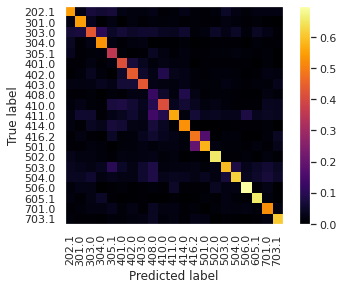

In [ ]:
scores_token_code = classify(code_df, 'TEXT_TOKEN', 'CODE', models)

Número de classes: 7
Número de amostras para treino: 65295
Número de amostras para teste: 16324
Começando treinamento no modelo SGDClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits

O modelo SGDClassifier levou 1 min para ser treinado.
Pipeline: ['vect', 'tfidf', 'model']
A melhor configuração de modelo encontrada foi:  Pipeline(steps=[('vect', CountVectorizer(max_df=0.75)),
                ('tfidf', TfidfTransformer()),
                ('model',
                 SGDClassifier(alpha=1e-05, max_iter=200,
                               penalty='elasticnet'))])
O melhor score: 0.56 %
              precision    recall  f1-score   support

           1       0.66      0.60      0.63       899
           2       0.56      0.45      0.50      1022
           3       0.55      0.45      0.49      1947
           4       0.65      0.75      0.69      4870
           5       0.67      0.74      0.70      5174
           6       0.58      0.41      0.48      1069
           7 

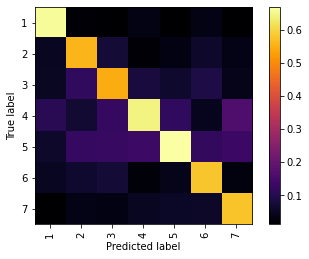

In [ ]:
scores_token_domain = classify(domain_df, 'TEXT_TOKEN', 'DOMAIN_CODE', models)

## Modelos Transformer-based

In [ ]:
def f1_micro(labels, preds):
    return sklearn.metrics.f1_score(labels, preds, average='micro')

def f1_macro(labels, preds):
    return sklearn.metrics.f1_score(labels, preds, average='macro')

def classify_bert(df, text, label, models):
    
    le = preprocessing.LabelEncoder()
    
    new_label = 'numerical_label'
    df[new_label] = le.fit_transform(df[label])

    print("Original label:")
    print(df[label].unique())

    label = new_label
    print("Encoded label:")
    print(df[new_label].unique())

    X_train, X_test, y_train, y_test = train_test_split(
        df[text], df[label], test_size=0.20, random_state=42)
    
    num_labels = df[label].nunique()

    train_data = list(zip(X_train, y_train))
    test_data = list(zip(X_test, y_test))

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    train_args={
        'num_train_epochs': 2,
        'logging_steps': 10,
        'learning_rate': 1e-5,
        'fp16': False,
        'overwrite_output_dir': True
    }

    scores = []
    for model in models:
        model_bert = ClassificationModel(model['model_type'], model['model_name'], num_labels=num_labels, use_cuda=True, cuda_device=0, args=train_args) 
        
        model_bert.train_model(train_df)
        result, model_outputs, wrong_predictions = model_bert.eval_model(test_df, f1_micro=f1_micro, f1_macro=f1_macro)

        scores.append({
            "result": result,
            "test_score_macro": [result['f1_macro']],
            "test_score_micro": [result['f1_micro']],
            "label_encoder": le
        })

    return scores

In [ ]:
models_bert = [
    # {
    #     "model_type": 'bert'
    #     , "model_name": 'bert-base-uncased'
    # } , 
    {
        "model_type": 'bert'
        , "model_name": 'liaad/srl-pt_bertimbau-base'
    }
]

In [ ]:
scores_bert_code = classify_bert(code_df, "TEXT_TOKEN", "CODE", models_bert)

Original label:
['202.1' '506.0' '701.0' '411.0' '504.0' '605.1' '501.0' '503.0' '416.2'
 '303.0' '403.0' '502.0' '301.0' '305.1' '408.0' '703.1' '304.0' '410.0'
 '414.0' '402.0' '401.0']
Encoded label:
[ 0 17 19 10 16 18 13 15 12  2  7 14  1  4  8 20  3  9 11  6  5]


Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at liaad/srl-pt_bertimbau-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/136 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/51135 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_21_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/6392 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/6392 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/12784 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_21_2


Running Evaluation:   0%|          | 0/1598 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5627437217244681, 'f1_micro': 0.5919899874843555, 'f1_macro': 0.5240390780294634, 'eval_loss': 1.409074484546656}


In [ ]:
scores_bert_code

[{'result': {'mcc': 0.5085732321137267,
   'f1_micro': 0.5424749687108886,
   'f1_macro': 0.4561289266386917,
   'eval_loss': 1.6153638376312351},
  'test_score_macro': [0.4561289266386917],
  'test_score_micro': [0.5424749687108886],
  'label_encoder': LabelEncoder()},
 {'result': {'mcc': 0.5617858206607574,
   'f1_micro': 0.5909730913642053,
   'f1_macro': 0.5253100012039716,
   'eval_loss': 1.4149321162786441},
  'test_score_macro': [0.5253100012039716],
  'test_score_micro': [0.5909730913642053],
  'label_encoder': LabelEncoder()}]

In [ ]:
scores_bert_domain = classify_bert(domain_df, "TEXT_TOKEN", "DOMAIN_CODE", models_bert)

Original label:
[2 5 7 4 6 3 1]
Encoded label:
[1 4 6 3 5 2 0]


Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at liaad/srl-pt_bertimbau-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/136 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/65295 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_7_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/8162 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/8162 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/16324 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_7_2


Running Evaluation:   0%|          | 0/2041 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5620911874180333, 'f1_micro': 0.6624601813281058, 'f1_macro': 0.6095624152027987, 'eval_loss': 0.9684509191368211}


In [ ]:
scores_bert_domain # BERT only

{'eval_loss': 1.0614129890492008,
 'f1_macro': 0.571470233530315,
 'f1_micro': 0.6318304337172261,
 'mcc': 0.5204044654424499}

In [ ]:
scores_bert_domain

[{'result': {'mcc': 0.5620911874180333,
   'f1_micro': 0.6624601813281058,
   'f1_macro': 0.6095624152027987,
   'eval_loss': 0.9684509191368211},
  'test_score_macro': [0.6095624152027987],
  'test_score_micro': [0.6624601813281058],
  'label_encoder': LabelEncoder()}]

In [ ]:
!zip -r /content/code_bertimbau_outputs.zip /content/outputs

  adding: content/outputs/ (stored 0%)
  adding: content/outputs/eval_results.txt (deflated 22%)
  adding: content/outputs/pytorch_model.bin (deflated 7%)
  adding: content/outputs/checkpoint-8000/ (stored 0%)
  adding: content/outputs/checkpoint-8000/pytorch_model.bin (deflated 7%)
  adding: content/outputs/checkpoint-8000/tokenizer_config.json (deflated 36%)
  adding: content/outputs/checkpoint-8000/scheduler.pt (deflated 49%)
  adding: content/outputs/checkpoint-8000/model_args.json (deflated 62%)
  adding: content/outputs/checkpoint-8000/special_tokens_map.json (deflated 40%)
  adding: content/outputs/checkpoint-8000/optimizer.pt (deflated 21%)
  adding: content/outputs/checkpoint-8000/vocab.txt (deflated 52%)
  adding: content/outputs/checkpoint-8000/training_args.bin (deflated 48%)
  adding: content/outputs/checkpoint-8000/config.json (deflated 63%)
  adding: content/outputs/checkpoint-8000/tokenizer.json (deflated 72%)
  adding: content/outputs/tokenizer_config.json (deflated 36

In [ ]:
!cp /content/code_bertimbau_outputs.zip '/content/drive/MyDrive/UnB/TCC/modelos/'

In [ ]:
from google.colab import files
files.download("/content/code_bertimbau_outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Resultados

In [ ]:
scores_token_code

[{'mean_fit_time': array([1.26284633]),
  'mean_score_time': array([0.2945168]),
  'mean_test_score': array([0.41943874]),
  'mean_train_score': array([0.86250945]),
  'param_model__alpha': masked_array(data=[0.01],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_vect__max_df': masked_array(data=[0.75],
               mask=[False],
         fill_value='?',
              dtype=object),
  'params': [{'model__alpha': 0.01, 'vect__max_df': 0.75}],
  'rank_test_score': array([1], dtype=int32),
  'split0_test_score': array([0.41887916]),
  'split0_train_score': array([0.8613638]),
  'split1_test_score': array([0.41913504]),
  'split1_train_score': array([0.86337315]),
  'split2_test_score': array([0.41486427]),
  'split2_train_score': array([0.86301669]),
  'split3_test_score': array([0.42664093]),
  'split3_train_score': array([0.86316714]),
  'split4_test_score': array([0.41767432]),
  'split4_train_score': array([0.86162647]),
  'std_fit_time': 

In [ ]:
scores_token_domain

[{'mean_fit_time': array([1.21141195]),
  'mean_score_time': array([0.25170083]),
  'mean_test_score': array([0.48055691]),
  'mean_train_score': array([0.79606361]),
  'param_model__alpha': masked_array(data=[0.01],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_vect__max_df': masked_array(data=[0.75],
               mask=[False],
         fill_value='?',
              dtype=object),
  'params': [{'model__alpha': 0.01, 'vect__max_df': 0.75}],
  'rank_test_score': array([1], dtype=int32),
  'split0_test_score': array([0.48761226]),
  'split0_train_score': array([0.79470486]),
  'split1_test_score': array([0.47696978]),
  'split1_train_score': array([0.79698203]),
  'split2_test_score': array([0.4873735]),
  'split2_train_score': array([0.79621637]),
  'split3_test_score': array([0.47475534]),
  'split3_train_score': array([0.79548054]),
  'split4_test_score': array([0.47607368]),
  'split4_train_score': array([0.79693424]),
  'std_fit_time':

In [ ]:
def create_scores_df(scores):
    scores_dict = {}
    for idx, model in enumerate(models):
        index_best = list(scores[idx]["rank_test_score"]).index(min(scores[idx]["rank_test_score"]))

        f1_scores = []
        for i in range(5):
            f1_scores.append(scores[idx][f"split{i}_test_score"][index_best])

        scores_dict[model['classifier'].__class__.__name__] = pd.Series(f1_scores)

    scores_dict
    scores_df = pd.DataFrame(scores_dict)
    
    return scores_df

In [ ]:
code_scores_df = create_scores_df(scores_token_code)
code_scores_df

,MultinomialNB,LogisticRegression,SGDClassifier,XGBClassifier
0,0.418879,0.462943,0.468041,0.423473
1,0.419135,0.465357,0.477713,0.435091
2,0.414864,0.467221,0.479224,0.429723
3,0.426641,0.469630,0.467452,0.417774
4,0.417674,0.471688,0.476529,0.425973


In [ ]:
domain_scores_df = create_scores_df(scores_token_domain)
domain_scores_df

,MultinomialNB,LogisticRegression,SGDClassifier,XGBClassifier
0,0.487612,0.544607,0.557860,0.440257
1,0.476970,0.538894,0.559073,0.431111
2,0.487374,0.541088,0.564095,0.438106
3,0.474755,0.536866,0.547867,0.440338
4,0.476074,0.526699,0.549247,0.436111


In [ ]:
# domain_scores_df.to_csv('/content/drive/MyDrive/UnB/TCC/modelos/manifestos_domain_scores.csv', index=False)
# code_scores_df.to_csv('/content/drive/MyDrive/UnB/TCC/modelos/manifestos_code_scores.csv', index=False)

domain_scores_df = pd.read_csv('/content/drive/MyDrive/UnB/TCC/modelos/manifestos_domain_scores.csv')
# code_scores_df = pd.read_csv('/content/drive/MyDrive/UnB/TCC/modelos/manifestos_code_scores.csv')

Adicionar resultados do BERT

In [ ]:
scores_bert_code = [
    {   
        'mcc': 0.5085732321137267,
        'f1_micro': 0.5424749687108886,
        'f1_macro': 0.4561289266386917,
        'eval_loss': 1.6153638376312351
    }
    , { 
        'mcc': 0.5617858206607574,
        'f1_micro': 0.5909730913642053,
        'f1_macro': 0.5253100012039716,
        'eval_loss': 1.4149321162786441
    }
]

In [ ]:
for idx, model in enumerate(models_bert):
    code_scores_df[model['model_name']] = pd.Series(scores_bert_code[idx]['f1_macro'])

code_scores_df

,MultinomialNB,LogisticRegression,SGDClassifier,XGBClassifier,bert-base-uncased,liaad/srl-pt_bertimbau-base
0,0.418879,0.462943,0.468041,0.423473,0.456129,0.52531
1,0.419135,0.465357,0.477713,0.435091,NaN,NaN
2,0.414864,0.467221,0.479224,0.429723,NaN,NaN
3,0.426641,0.469630,0.467452,0.417774,NaN,NaN
4,0.417674,0.471688,0.476529,0.425973,NaN,NaN


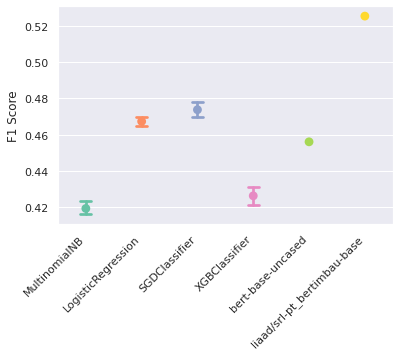

In [ ]:
sns.pointplot(data=code_scores_df, join=False, capsize=.2, palette="Set2")
plt.ylabel('F1 Score');
plt.xticks(rotation=45, ha='right')

plt.savefig(f"/content/drive/MyDrive/UnB/TCC/modelos/manifestos_code_resultados.png", bbox_inches="tight")

In [ ]:
scores_bert_domain = [
    {   
        'mcc': 0.5204044654424499,
        'f1_micro': 0.6318304337172261,
        'f1_macro': 0.571470233530315,
        'eval_loss': 1.0614129890492008
    }
    , { 
        'mcc': 0.5620911874180333,
        'f1_micro': 0.6624601813281058,
        'f1_macro': 0.6095624152027987,
        'eval_loss': 0.9684509191368211
    }
]

In [ ]:
for idx, model in enumerate(models_bert):
    domain_scores_df[model['model_name']] = pd.Series(scores_bert_domain[idx]['f1_macro'])

domain_scores_df

,MultinomialNB,LogisticRegression,SGDClassifier,XGBClassifier,bert-base-uncased,liaad/srl-pt_bertimbau-base
0,0.487612,0.544607,0.557860,0.440257,0.57147,0.609562
1,0.476970,0.538894,0.559073,0.431111,NaN,NaN
2,0.487374,0.541088,0.564095,0.438106,NaN,NaN
3,0.474755,0.536866,0.547867,0.440338,NaN,NaN
4,0.476074,0.526699,0.549247,0.436111,NaN,NaN


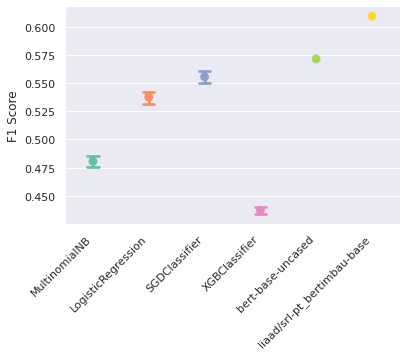

In [ ]:
sns.pointplot(data=domain_scores_df, join=False, capsize=.2, palette="Set2")
plt.ylabel('F1 Score');
plt.xticks(rotation=45, ha='right')

plt.savefig(f"/content/drive/MyDrive/UnB/TCC/modelos/manifestos_domain_resultados.png", bbox_inches="tight")

Calcular média e intervalo de confiança

In [ ]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def calculate_model_scores(scores_df):
    print("Métricas de score dos modelos:")
    print(scores_df.describe())
    print("\nIntervalos de confiança para os modelos:")
    for model in scores_df.columns:
        _, l , h = mean_confidence_interval(list(scores_df[model]))
        print(f"{model}: ({round(l, 3)} {round(h, 3)})")

In [ ]:
calculate_model_scores(code_scores_df)

Métricas de score dos modelos:
       MultinomialNB  LogisticRegression  SGDClassifier  XGBClassifier
count       5.000000            5.000000       5.000000       5.000000
mean        0.419439            0.467368       0.473792       0.426407
std         0.004368            0.003443       0.005604       0.006514
min         0.414864            0.462943       0.467452       0.417774
25%         0.417674            0.465357       0.468041       0.423473
50%         0.418879            0.467221       0.476529       0.425973
75%         0.419135            0.469630       0.477713       0.429723
max         0.426641            0.471688       0.479224       0.435091

Intervalos de confiança para os modelos:
MultinomialNB: (0.414 0.425)
LogisticRegression: (0.463 0.472)
SGDClassifier: (0.467 0.481)
XGBClassifier: (0.418 0.434)


In [ ]:
calculate_model_scores(domain_scores_df)

Métricas de score dos modelos:
       MultinomialNB  LogisticRegression  SGDClassifier  XGBClassifier
count       5.000000            5.000000       5.000000       5.000000
mean        0.480557            0.537631       0.555628       0.437185
std         0.006381            0.006751       0.006883       0.003817
min         0.474755            0.526699       0.547867       0.431111
25%         0.476074            0.536866       0.549247       0.436111
50%         0.476970            0.538894       0.557860       0.438106
75%         0.487374            0.541088       0.559073       0.440257
max         0.487612            0.544607       0.564095       0.440338

Intervalos de confiança para os modelos:
MultinomialNB: (0.473 0.488)
LogisticRegression: (0.529 0.546)
SGDClassifier: (0.547 0.564)
XGBClassifier: (0.432 0.442)
